<a href="https://www.kaggle.com/code/ov0qsm/hw3-cnn?scriptVersionId=103046586" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/working/__notebook__.ipynb


In [2]:
!conda install -y gdown
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.8.0             |     pyhd8ed1ab_0          13 KB  conda-forge
    gdown-4.5.1                |     pyhd8ed1ab_0          17 KB  conda-forge
    ------------------------------------------------------------
                                           Total:    

In [3]:
!unzip -q food-11.zip

In [4]:
os.getcwd()

'/kaggle/working'

In [5]:
!pip install torchsummary

In [6]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.(没用上)
#from tqdm.auto import tqdm

# This is for plotting
import matplotlib.pyplot as plt

# This is to visualize the network
from torchsummary import summary

In [7]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomChoice(
        [transforms.AutoAugment(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.7, 1.3)),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [8]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last = True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
#test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [9]:
unlabeled_set[0][0].size()

torch.Size([3, 128, 128])

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0),

            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(4*4*1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.6),

            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [11]:
class PseudoDataset(Dataset):
    def __init__(self,X, y):
        self.data = X
        self.label = y
      

    def __getitem__(self, idx):
        return self.data[idx][0], self.label[idx]  #这里self.data[idx]是包含tensor的元组，所以再加一个[0]取出tensor
       
    def __len__(self):
        return len(self.label)



def get_pseudo_labels(dataset, model, threshold=0.75):  #参数待修改
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    idx = []
    labels = []

    # Iterate over the dataset by batches.
    for i, batch in enumerate(data_loader):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # ---------- TODO ----------
        # Filter the data and construct a new dataset.
        for j,x in enumerate(probs):
            if torch.max(x) > threshold:
                idx.append(i * batch_size + j)
                labels.append(int(torch.argmax(x)))

    print ("\nNew data: {:5d}\n".format(len(idx)))
    dataset = PseudoDataset(Subset(dataset, idx), labels)


    # # Turn off the eval mode.
    model.train()
    return dataset

In [12]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 400

# Whether to do semi-supervised learning.
do_semi = True

# To record loss and accuracy
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []

# To save the best model on val_set
best_acc = 0
model_path = 'model.ckpt'

# To visualize the network
summary(model, input_size=(3, 128, 128), device=device)

for epoch in range(n_epochs):
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if do_semi and best_acc > 0.7: 
        # Obtain pseudo-labels for unlabeled data using trained model.
        pseudo_set = get_pseudo_labels(unlabeled_set, model)

        # Construct a new dataset and a data loader for training.
        # This is used in semi-supervised learning only.
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        # 这里 drop_last = True是为了避免正好最后一个batch只有一个样本batch normalization报错的倒霉情况
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True,drop_last = True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    # for batch in tqdm(train_loader):  使用tqdm不知为何总会出问题
    for batch in train_loader:
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_record.append(train_loss)
    train_acc_record.append(train_acc)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    # for batch in tqdm(valid_loader):
    for batch in valid_loader:

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    val_loss_record.append(valid_loss)
    val_acc_record.append(valid_acc)

   
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
     
    #----------Record----------#
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print("Saving model with acc{:.3f}".format(best_acc))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
       BatchNorm2d-6          [-1, 128, 64, 64]             256
              ReLU-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         295,168
      BatchNorm2d-10          [-1, 256, 32, 32]             512
             ReLU-11          [-1, 256, 32, 32]               0
        MaxPool2d-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
      BatchNorm2d-14          [-1, 512,

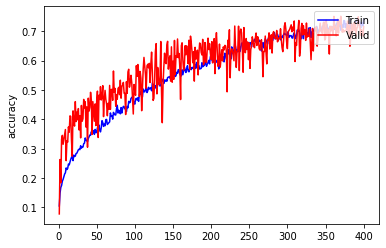

In [13]:
x = np.arange(1, len(train_acc_record)+1)
plt.plot(x, train_acc_record, color="blue", label="Train")
plt.plot(x, val_acc_record, color="red", label="Valid")
plt.legend(loc="upper right")
plt.ylabel('accuracy')
plt.show()

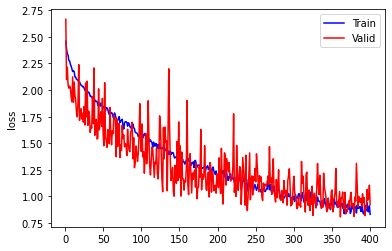

In [14]:
x = np.arange(1, 1+len(train_loss_record))
plt.plot(x, train_loss_record, color="blue", label="Train")
plt.plot(x, val_loss_record, color="red", label="Valid")
plt.legend(loc="upper right") 
plt.ylabel('loss')
plt.show()

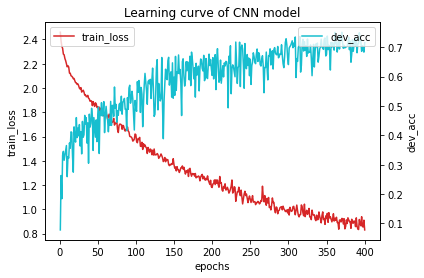

In [15]:
from matplotlib.pyplot import figure
  

fig = figure(figsize = (6,4))
ax1 = fig.add_subplot(111)
ax1.plot(x,train_loss_record, c = 'tab:red', label = 'train_loss')
ax2 = ax1.twinx()
ax2.plot(x,val_acc_record, c='tab:cyan', label='dev_acc')
ax1.set_xlabel('epochs')
ax1.set_ylabel('train_loss')
ax2.set_ylabel('dev_acc')
plt.title('Learning curve of CNN model')
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

